In [1]:
import os
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from glob import glob
import random
from torch.utils import data
from torchvision import transforms
import pickle
import cv2
%matplotlib inline

In [2]:
TRAIN_PATH = '../data/stage1_train'
TEST_PATH = '../data/stage1_test'

In [3]:
image_folders = glob(f"{TRAIN_PATH}/*")

In [4]:
sample_folder = random.choice(image_folders)

In [5]:
def get_masks(folder_path):
    masks_paths = glob(f"{folder_path}/masks/*") 
    return [mpimg.imread(p) for p in masks_paths]

def get_image(folder_path): 
    image_path, = glob(f"{folder_path}/images/*")
    return mpimg.imread(image_path)

def stack_masks(masks):
    stacked_mask = np.zeros_like(masks[0])
    for mask in masks:
        stacked_mask += mask
    return stacked_mask

## Test on one folder

In [6]:
image = get_image(sample_folder)
masks = get_masks(sample_folder)
stacked_mask = stack_masks(masks)

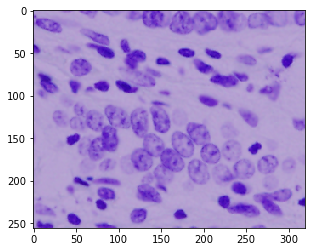

In [7]:
plt.imshow(image)

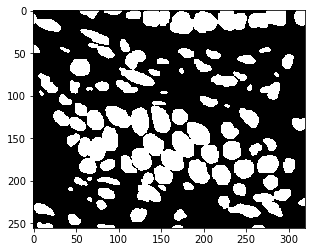

In [8]:
plt.imshow(stack_masks(masks), cmap='gray')

## Now create preprocess training data

In [9]:
# all_images = []
# for path in tqdm(image_folders):
#     all_images.append(get_image(path))
# all_images = np.array(all_images)

In [10]:
# all_masks = []
# for path in tqdm(image_folders):
#     all_masks.append(get_masks(path))

In [11]:
# all_stacked_masks = []
# for masks in tqdm(all_masks):
#     all_stacked_masks.append(stack_masks(masks))
# all_stacked_masks = np.array(all_stacked_masks)

In [12]:
# pickle.dump(all_images, open("training_images.p", "wb")) 

In [13]:
# pickle.dump(all_stacked_masks, open("stacked_masks.p", "wb"))

## Create the dataset

In [14]:
all_images = pickle.load(open("training_images.p", "rb"))

In [15]:
all_stacked_masks = pickle.load(open("stacked_masks.p", "rb"))

In [16]:
from sklearn.model_selection import KFold

In [17]:
kf = KFold(n_splits = 8, shuffle=True)

In [18]:
for train_idx, test_idx in kf.split(all_images):
    train_images, val_images = all_images[train_idx], all_images[test_idx]
    train_masks, val_masks = all_stacked_masks[train_idx], all_stacked_masks[test_idx]
    break

In [19]:
def convert_image_to_tensor(image):
    return torch.from_numpy(image).type(torch.FloatTensor)

def resize_image(image):
    return cv2.resize(image, (128, 128))

def convert_to_CHW(tensor):
    return tensor.permute(2, 0, 1)

class NucleiDataset(data.Dataset):
    def __init__(self, input_image, stacked_masks, is_train):
        self.X = input_image
        self.y = stacked_masks
        self.input_transform = transforms.Compose([
            resize_image,
            convert_image_to_tensor, 
            convert_to_CHW,
        ])
        self.mask_transform = transforms.Compose([
            resize_image, 
            convert_image_to_tensor
        ])
        self.is_train = is_train
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
         return {
             "input": self.input_transform(self.X[i]),
             "mask": self.mask_transform(self.y[i])
         }

In [20]:
train_ds = NucleiDataset(train_images, train_masks, is_train=True)
train_dl = data.DataLoader(train_ds, batch_size=3, shuffle=True)
val_ds = NucleiDataset(val_images, val_masks, is_train=False)
val_dl = data.DataLoader(val_ds, batch_size=3, shuffle=False)

## Check if the input image and associated mask is correct after transforms

In [21]:
sample_data = random.choice(train_ds)

In [22]:
sample_input = sample_data['input'].permute(1, 2, 0)
sample_mask = sample_data['mask']

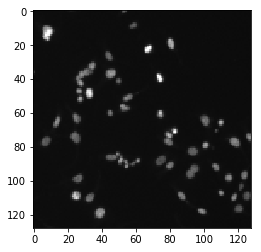

In [23]:
plt.imshow(sample_input)

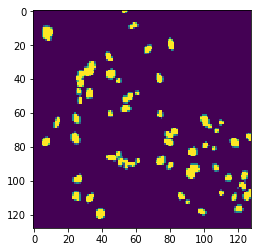

In [24]:
plt.imshow(sample_mask)

## Now we define the U-Net architecture

![title](U-Net.png)

#### Before defining U-Net, figure out nn.ConvTranspose2d

In [180]:
conv_t = nn.ConvTranspose2d(1, 1, 2, stride=1)
conv_t.bias = nn.Parameter(torch.from_numpy(np.array([0]).astype(np.float32)))
# conv_t.weight = nn.Parameter(torch.from_numpy(np.random.randint(low=0, high=5, size=(1,1,2,2)).astype(np.float32)))
conv_t.weight = nn.Parameter(torch.from_numpy(np.array([[[[4, 2],
                                                     [0, 1]]]]).astype(np.float32)))

In [181]:
conv = nn.Conv2d(1, 1, 2, stride=1)
conv.bias = conv_t.bias
conv.weight = conv_t.weight

In [182]:
# inp = Variable(torch.from_numpy(np.random.randint(low=0, high=5, size=(1, 1,3,3)))).float()
inp = Variable(torch.from_numpy(np.array([[[[1, 1, 3],
                                            [2, 3, 1],
                                            [4, 0, 4]]]]).astype(np.float32)))

In [183]:
inp

Variable containing:
(0 ,0 ,.,.) = 
  1  1  3
  2  3  1
  4  0  4
[torch.FloatTensor of size 1x1x3x3]

In [184]:
conv.weight

Parameter containing:
(0 ,0 ,.,.) = 
  4  2
  0  1
[torch.FloatTensor of size 1x1x2x2]

In [185]:
conv.bias

Parameter containing:
 0
[torch.FloatTensor of size 1]

In [186]:
inp

Variable containing:
(0 ,0 ,.,.) = 
  1  1  3
  2  3  1
  4  0  4
[torch.FloatTensor of size 1x1x3x3]

In [189]:
conv(inp)

Variable containing:
(0 ,0 ,.,.) = 
   9  11
  14  18
[torch.FloatTensor of size 1x1x2x2]

In [190]:
conv_t.weight

Parameter containing:
(0 ,0 ,.,.) = 
  4  2
  0  1
[torch.FloatTensor of size 1x1x2x2]

In [191]:
conv_t.bias

Parameter containing:
 0
[torch.FloatTensor of size 1]

In [192]:
inp

Variable containing:
(0 ,0 ,.,.) = 
  1  1  3
  2  3  1
  4  0  4
[torch.FloatTensor of size 1x1x3x3]

In [193]:
conv_t(inp)

Variable containing:
(0 ,0 ,.,.) = 
   4   6  14   6
   8  17  11   5
  16  10  19   9
   0   4   0   4
[torch.FloatTensor of size 1x1x4x4]

In [ ]:
class ConvBnRelu(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, padding=1, kernel_size=3, stride=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
        
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_bn_relu_1 = ConvBnRelu(in_channels, in_channels)
        self.conv_bn_relu_2 = ConvBnRelu(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)
    
    def forward(x):
        x = self.conv_bn_relu_1(x)
        x = self.conv_bn_relu_2(x)
        x_down_sampled = self.pool(x)
        return x_down_sampled, x



class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__() 
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)        
        self.conv_bn_relu_1 = ConvBnRelu(in_channels, out_channels)
        self.conv_bn_relu_2 = ConvBnRelu(out_channels, out_channels)
    
    def forward(x, encoded):
        x = self.conv_transpose(x)
        x = torch.cat([x, encoded], 1)
        x = self.conv_bn_relu_1(x)
        x = self.conv_bn_relu_2(x)
        return x
    
    
class UNet(nn.Module):
    def __init__(self, n_input_channels):
        self.down_sample_1 = DownSample(n_input_channels, 64)
        self.down_sample_2 = DownSample(64, 128)
        self.down_sample_3 = DownSample(128, 256)
        self.down_sample_4 = DownSample(256, 512)
        self.middle = nn.Sequential(
            ConvBnRelu(512, 1024)
            ConvBnRelu(1024, 1024)
            ConvBnRelu(1024, 512)
        )
        self.up_sample_1 = UpSample(1024, 512)
        self.up_sample_2 = UpSample(512, 256)
        self.up_sample_3 = UpSample(256, 128)
        self.up_sample_4 = UpSample(128, 64)
    
    def forward(x):
        x_1, x = self.down_sample_1(x)
        x_2, x = self.down_sample_2(x)
        x_3, x = self.down_sample_3(x)
        x_4, x = self.down_sample_4(x)
        x = self.middle(x)
        x = self.up_sample_1(x, x_4)
        x = self.up_sample_2(x, x_3)
        x = self.up_sample_3(x, x_2)
        x = self.up_sample_4(x, x_1)
        return x

In [165]:
inp = np.array([1, 1, 3, 2, 3, 1, 4, 0, 4])
inp

array([1, 1, 3, 2, 3, 1, 4, 0, 4])

In [167]:
kernel = np.array([[4, 0, 0, 0],
                   [2, 4, 0, 0],
                   [0, 2, 0, 0],
                   [0, 0, 4, 0],
                   [1, 0, 2, 4],
                   [0, 1, 0, 2],
                   [0, 0, 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])

In [169]:
np.reshape(inp.dot(kernel), (2, 2))

array([[ 9, 11],
       [14, 18]])

In [ ]:
output = m(inp)